In [9]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
%matplotlib inline

We'll start simple, with a single fully-connected neural layer as encoder and as decoder

In [2]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model

In [11]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [12]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [13]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

How does our model look like?

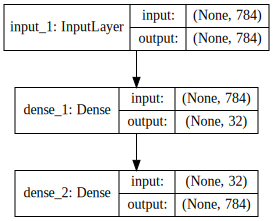

In [15]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [14]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [17]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [18]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.3614 - val_loss: 0.2717
Epoch 2/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.2656 - val_loss: 0.2559
Epoch 3/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.2457 - val_loss: 0.2329
Epoch 4/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.2240 - val_loss: 0.2129
Epoch 5/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.2074 - val_loss: 0.1995
Epoch 6/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.1964 - val_loss: 0.1904
Epoch 7/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1882 - val_loss: 0.1833
Epoch 8/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.1815 - val_loss: 0.1769
Epoch 9/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.1757 - val_loss: 0.1715
Epoch

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [19]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

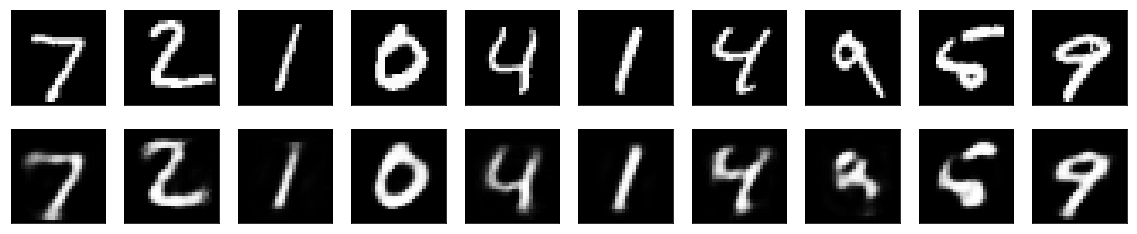

In [21]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()